In [106]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import umap
from torch.nn.functional import mse_loss
from tqdm import tqdm
from sklearn.decomposition import PCA

from autoencoder import Autoencoder
from solver import *

In [107]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=6)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [108]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [109]:
modelpath = f'/home/david/sparsify_models/good_models/01'

sae = load_model(modelpath, 'SAE', epoch=49)
dae = load_model(modelpath, 'DAE', epoch=49)

/tmp/ipykernel_21650/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


In [110]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [121]:
def add_noise_and_reconstruct(test_images, noise_scale, n_components=32, start_noise_idx=0, end_noise_idx=4):
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_reduced = pca.fit_transform(torch.tensor(test_images.reshape(len(test_images), -1)))
    
    # Add different noise to each PCA reduced image to specified PCs
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=(len(pca_reduced), end_noise_idx-start_noise_idx))
    pca_reduced[:, start_noise_idx:end_noise_idx] += noise
    
    # Reconstruct
    return pca.inverse_transform(pca_reduced).reshape(len(test_images), 28, 28)

In [112]:
def evaluate_models(test_images, reconstructed_images, sae, dae):
    sae_diffs = []
    dae_diffs = []
    
    for i in range(len(test_images)):
        test_image = torch.tensor(test_images[i].reshape(-1), dtype=torch.float32)
        reconstructed_image = torch.tensor(reconstructed_images[i].reshape(-1), dtype=torch.float32)
        
        # SAE evaluation
        test_encoding = sae.encode(test_image)
        reconstructed_encoding = sae.encode(reconstructed_image)
        diff = np.abs((test_encoding - reconstructed_encoding).detach().numpy())
        sae_diffs.append(diff)
        
        # DAE evaluation
        test_encoding = dae.encode(test_image)
        reconstructed_encoding = dae.encode(reconstructed_image)
        diff = np.abs((test_encoding - reconstructed_encoding).detach().numpy())
        dae_diffs.append(diff)
    
    return np.mean(np.vstack(sae_diffs), axis=0), np.mean(np.vstack(dae_diffs), axis=0)

In [122]:
def plot_noise_comparison(results, noise_levels, title):

    plt.figure(figsize=(12, 8))
    
    # Color gradients
    sae_colors = plt.cm.Blues(np.linspace(0.3, 1, len(noise_levels)))
    dae_colors = plt.cm.Reds(np.linspace(0.3, 1, len(noise_levels)))
    
    for i, noise_level in enumerate(noise_levels):
        sae_data = np.vstack([run[0] for run in results[noise_level]])
        dae_data = np.vstack([run[1] for run in results[noise_level]])
        
        # Calculate statistics
        sae_mean = np.mean(sae_data, axis=0)
        sae_std = np.std(sae_data, axis=0)
        dae_mean = np.mean(dae_data, axis=0)
        dae_std = np.std(dae_data, axis=0)
        
        # Plot SAE
        plt.plot(sae_mean, color=sae_colors[i], 
                label=f'SAE (σ={noise_level})', linewidth=2)
        plt.fill_between(range(len(sae_mean)), 
                        sae_mean - sae_std, 
                        sae_mean + sae_std,
                        color=sae_colors[i], alpha=0.1)
        
        # Plot DAE
        plt.plot(dae_mean, color=dae_colors[i], 
                label=f'DAE (σ={noise_level})', linewidth=2)
        plt.fill_between(range(len(dae_mean)),
                        dae_mean - dae_std,
                        dae_mean + dae_std,
                        color=dae_colors[i], alpha=0.1)
    
    plt.title(title)
    plt.xlabel("Neuron Index")
    plt.ylabel("Absolute Activation Difference")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [129]:
def plot_neuron_comparison(results, manipulated_neurons, title):

    plt.figure(figsize=(12, 8))
    
    # Color gradients
    sae_colors = plt.cm.Blues(np.linspace(0.3, 1, len(manipulated_neurons)))
    dae_colors = plt.cm.Reds(np.linspace(0.3, 1, len(manipulated_neurons)))
    
    for i, neuron_pair in enumerate(manipulated_neurons):
        sae_data = np.vstack([run[0] for run in results[neuron_pair]])
        dae_data = np.vstack([run[1] for run in results[neuron_pair]])
        
        # Calculate statistics
        sae_mean = np.mean(sae_data, axis=0)
        sae_std = np.std(sae_data, axis=0)
        dae_mean = np.mean(dae_data, axis=0)
        dae_std = np.std(dae_data, axis=0)
        
        # Plot SAE
        plt.plot(sae_mean, color=sae_colors[i], 
                label=f'SAE (Noisy PCs: {manipulated_neurons[i][0]} - {manipulated_neurons[i][1]-1})', linewidth=2)
        plt.fill_between(range(len(sae_mean)), 
                        sae_mean - sae_std, 
                        sae_mean + sae_std,
                        color=sae_colors[i], alpha=0.1)
        
        # Plot DAE
        plt.plot(dae_mean, color=dae_colors[i], 
                label=f'DAE (Noisy PCs: {manipulated_neurons[i][0]} - {manipulated_neurons[i][1]-1})', linewidth=2)
        plt.fill_between(range(len(dae_mean)),
                        dae_mean - dae_std,
                        dae_mean + dae_std,
                        color=dae_colors[i], alpha=0.1)
    
    plt.title(title)
    plt.xlabel("Neuron Index")
    plt.ylabel("Absolute Activation Difference")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Processing noise levels:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21650/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{mo

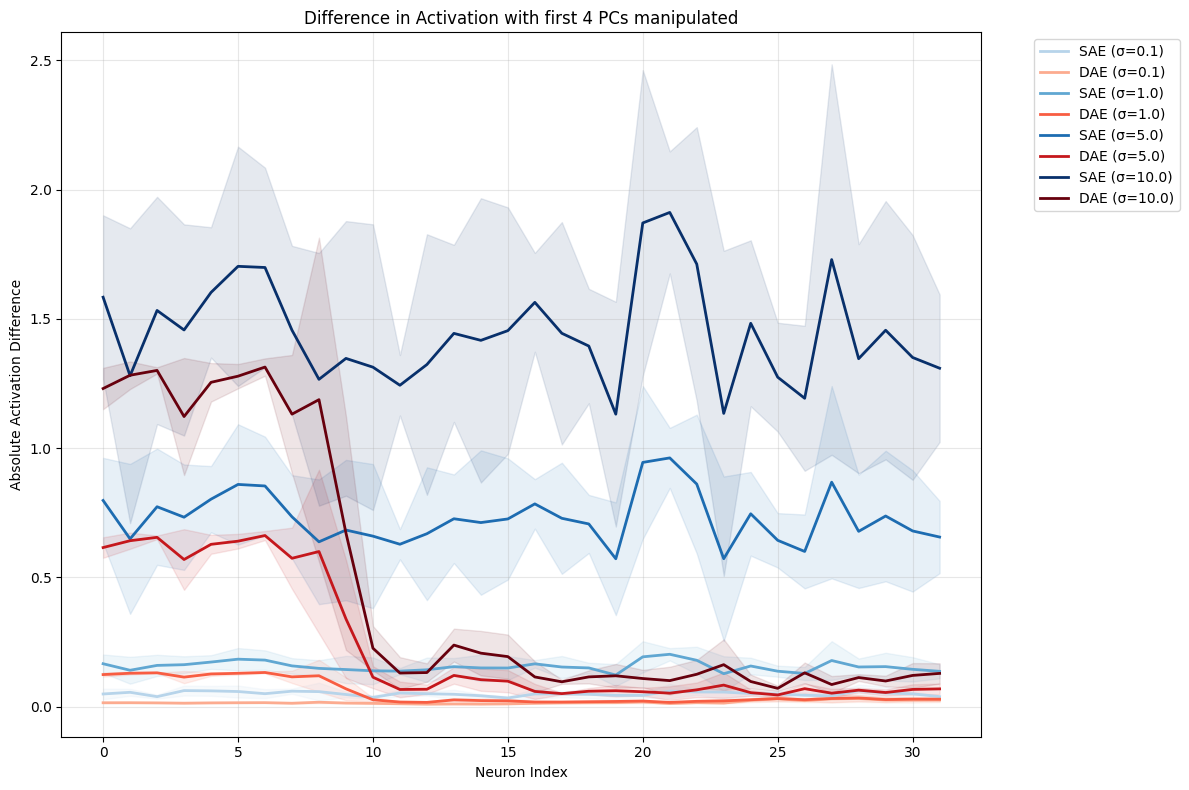

In [114]:
noise_levels = [0.1, 1.0, 5.0, 10.0]
results = {level: [] for level in noise_levels}

# Outer loop for noise levels
for noise_scale in tqdm(noise_levels, desc="Processing noise levels"):
    # Generate noisy images
    noisy_reconstructed = add_noise_and_reconstruct(test_images, noise_scale, start_noise_idx=0, end_noise_idx=4)
    
    # Inner loop for model iterations
    for iteration in tqdm(range(1, 6), desc=f"Processing models (noise σ={noise_scale})", leave=False):
        modelpath = f'/home/david/sparsify_models/good_models/0{iteration}'
        sae = load_model(modelpath, 'SAE', 49)
        dae = load_model(modelpath, 'DAE', 49)
        
        # Evaluate models
        sae_diffs, dae_diffs = evaluate_models(test_images, noisy_reconstructed, sae, dae)
        results[noise_scale].append((sae_diffs, dae_diffs))

# Plot results
plot_noise_comparison(results, noise_levels, "Activation Differences (PCs 0-3 manipulated)")

Processing noise levels:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21650/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{mo

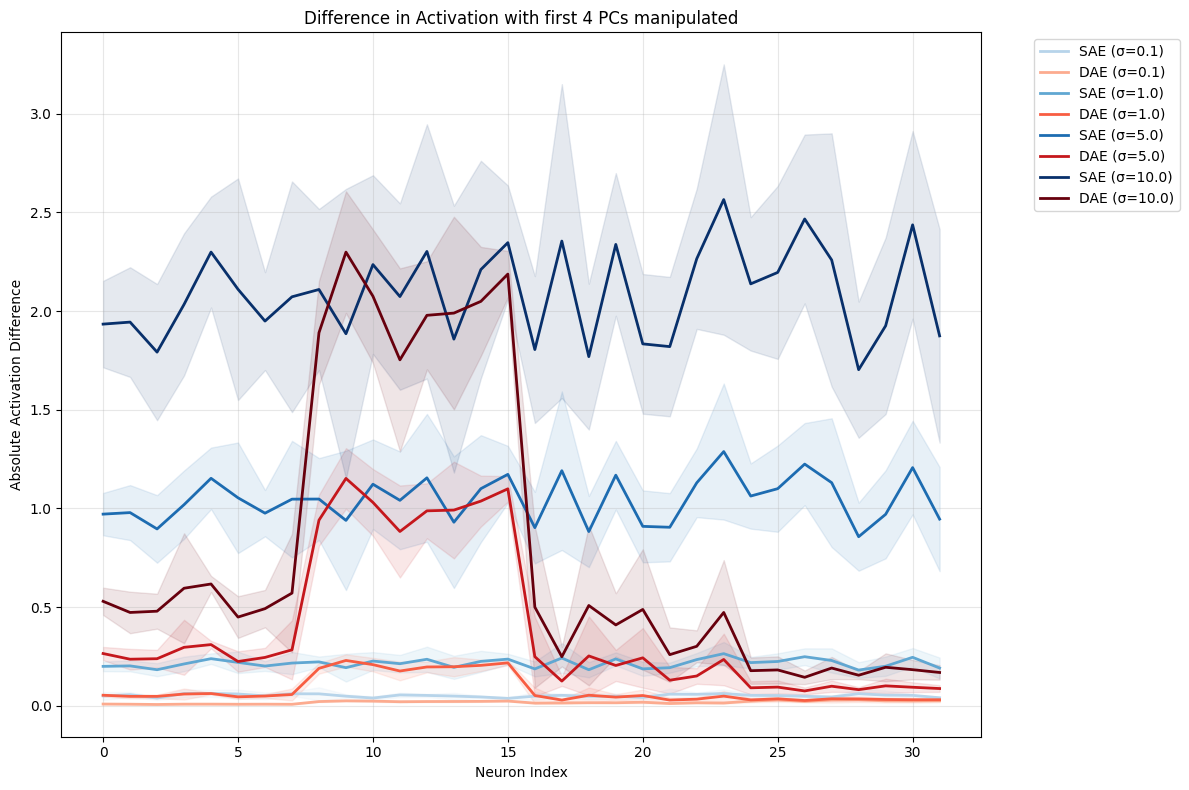

In [117]:
noise_levels = [0.1, 1.0, 5.0, 10.0]
results = {level: [] for level in noise_levels}

# Outer loop for noise levels
for noise_scale in tqdm(noise_levels, desc="Processing noise levels"):
    # Generate noisy images
    noisy_reconstructed = add_noise_and_reconstruct(test_images, noise_scale, start_noise_idx=4, end_noise_idx=11)
    
    # Inner loop for model iterations
    for iteration in tqdm(range(1, 6), desc=f"Processing models (noise σ={noise_scale})", leave=False):
        modelpath = f'/home/david/sparsify_models/good_models/0{iteration}'
        sae = load_model(modelpath, 'SAE', 49)
        dae = load_model(modelpath, 'DAE', 49)
        
        # Evaluate models
        sae_diffs, dae_diffs = evaluate_models(test_images, noisy_reconstructed, sae, dae)
        results[noise_scale].append((sae_diffs, dae_diffs))

# Plot results
plot_noise_comparison(results, noise_levels, "Activation Differences (PCs 4-10 manipulated)")

Processing noise levels:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21650/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{mo

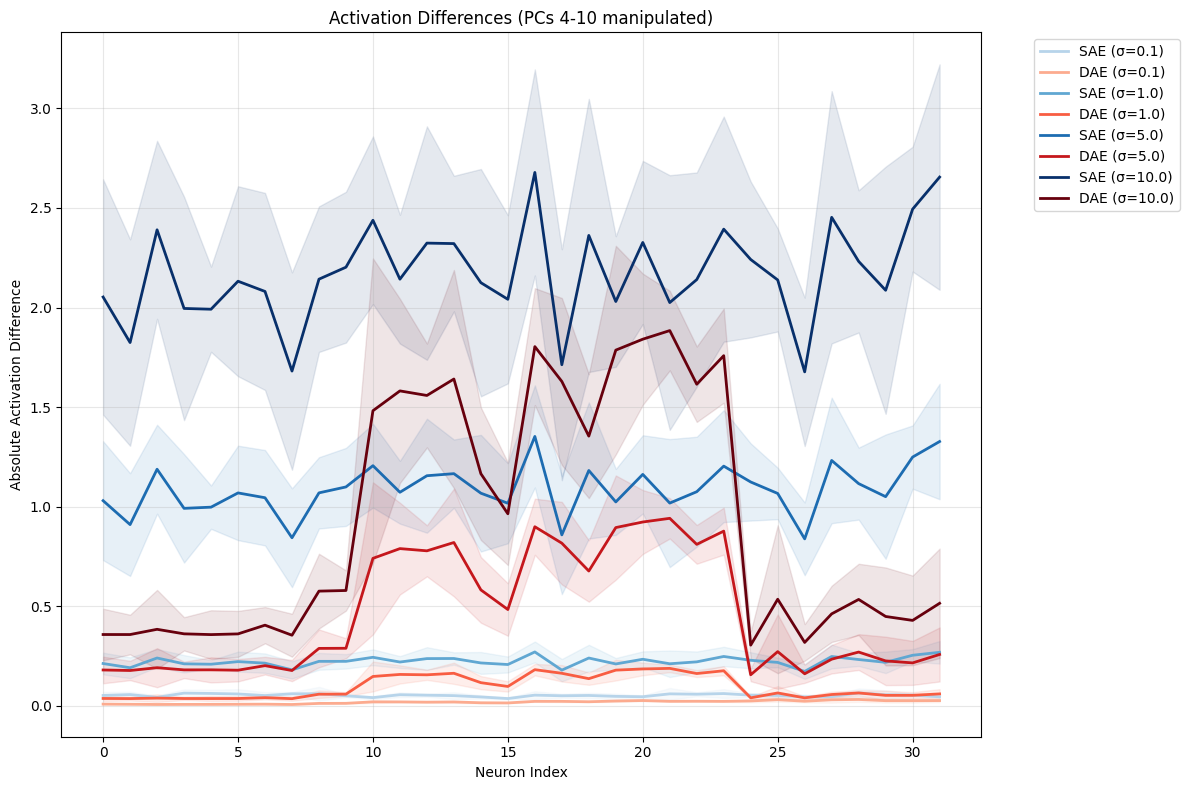

In [123]:
noise_levels = [0.1, 1.0, 5.0, 10.0]
results = {level: [] for level in noise_levels}

# Outer loop for noise levels
for noise_scale in tqdm(noise_levels, desc="Processing noise levels"):
    # Generate noisy images
    noisy_reconstructed = add_noise_and_reconstruct(test_images, noise_scale, start_noise_idx=10, end_noise_idx=17)
    
    # Inner loop for model iterations
    for iteration in tqdm(range(1, 6), desc=f"Processing models (noise σ={noise_scale})", leave=False):
        modelpath = f'/home/david/sparsify_models/good_models/0{iteration}'
        sae = load_model(modelpath, 'SAE', 49)
        dae = load_model(modelpath, 'DAE', 49)
        
        # Evaluate models
        sae_diffs, dae_diffs = evaluate_models(test_images, noisy_reconstructed, sae, dae)
        results[noise_scale].append((sae_diffs, dae_diffs))

# Plot results
plot_noise_comparison(results, noise_levels, "Activation Differences (PCs 10-16 manipulated)")

/tmp/ipykernel_21650/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
/tmp/i

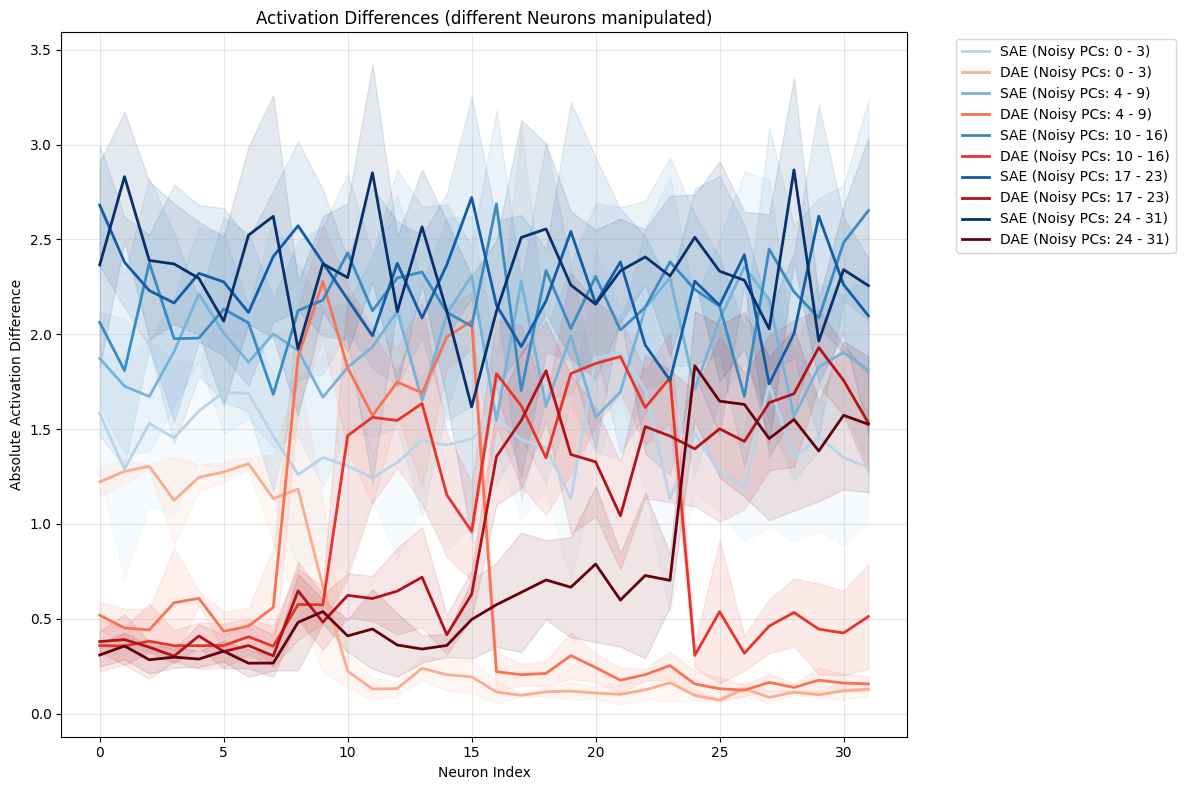

In [130]:
manipulated_neurons = [(0, 4), (4, 10), (10, 17), (17, 24), (24, 32)]
results = {pair: [] for pair in manipulated_neurons}

# Outer loop for noise levels
for neuron_pair in manipulated_neurons:
    # Generate noisy images
    noisy_reconstructed = add_noise_and_reconstruct(test_images, noise_scale=10, start_noise_idx=neuron_pair[0], end_noise_idx=neuron_pair[1])
    
    # Inner loop for model iterations
    for iteration in range(1, 6):
        modelpath = f'/home/david/sparsify_models/good_models/0{iteration}'
        sae = load_model(modelpath, 'SAE', 49)
        dae = load_model(modelpath, 'DAE', 49)
        
        # Evaluate models
        sae_diffs, dae_diffs = evaluate_models(test_images, noisy_reconstructed, sae, dae)
        results[neuron_pair].append((sae_diffs, dae_diffs))

# Plot results
plot_neuron_comparison(results, manipulated_neurons, "Activation Differences (different Neurons manipulated)")